# Setting

## input setting

In [1]:
import pandas as pd

print('loading train...', flush=True, end='')

# x를 loading해서 (batch_size, step, channel)
#input_path = '../dataset/preprocess4/input2/PPG_100Hz/'
input_path = 'dataset/preprocess6/input/'

x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
y_train_pacu =  np.load(input_path+'y_train_pacu.npz')['arr_0']


x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']


x_val_pacu = np.load(input_path+'x_val_pacu.npz', allow_pickle=True)['arr_0']
y_val_pacu =  np.load(input_path+'y_val_pacu.npz')['arr_0']


#print('x_train shape:', x_train.shape)
print('x_train shape:', x_train_pacu.shape)
print('x_test.shape:', x_test_pacu.shape)
print('x_val.shape:', x_val_pacu.shape)

print('done', flush=True)


loading train...x_train shape: (120609, 5000, 2)
x_test.shape: (14522, 5000, 2)
x_val.shape: (13602, 5000, 2)
done


In [2]:
# train_pacu: age+gender
age_train_pacu = np.load(input_path+'age_train_pacu.npz', allow_pickle=True)['arr_0']
gender_train_pacu = np.load(input_path+'gender_train_pacu.npz', allow_pickle=True)['arr_0']

agender_train_pacu = np.array([[age_train_pacu[i], gender_train_pacu[i]] for i in range(len(age_train_pacu))])


# val: age+gender
age_val_pacu = np.load(input_path+'age_val_pacu.npz', allow_pickle=True)['arr_0']
gender_val_pacu = np.load(input_path+'gender_val_pacu.npz', allow_pickle=True)['arr_0']

agender_val_pacu = np.array([[age_val_pacu[i], gender_val_pacu[i]] for i in range(len(age_val_pacu))])


# test: age+gender
age_test_pacu = np.load(input_path+'age_test_pacu.npz', allow_pickle=True)['arr_0']
gender_test_pacu = np.load(input_path+'gender_test_pacu.npz', allow_pickle=True)['arr_0']

agender_test_pacu = np.array([[age_test_pacu[i], gender_test_pacu[i]] for i in range(len(age_test_pacu))])


# 3 class에 대한 sample weight
train_w_samp3 = np.ones(shape=(len(y_train_pacu),))

train_w_samp3[y_train_pacu<4]= len(y_train_pacu)/np.sum(y_train_pacu<4)
train_w_samp3[(4<=y_train_pacu)&(y_train_pacu<7)]= len(y_train_pacu)/np.sum((4<=y_train_pacu)&(y_train_pacu<7))
train_w_samp3[7<=y_train_pacu]= len(y_train_pacu)/np.sum(7<=y_train_pacu)

print('train_pacu set')
print('sample weight for class 1: {:.2f}, class 2: {:.2f}, class 3: {:.2f}\n'
      .format(len(y_train_pacu)/np.sum(y_train_pacu<4),len(y_train_pacu)/np.sum((4<=y_train_pacu)&(y_train_pacu<7)),len(y_train_pacu)/np.sum(7<=y_train_pacu)))

train_pacu set
sample weight for class 1: 4.91, class 2: 1.61, class 3: 5.67



## gpu setting

In [5]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K
from keras import regularizers
from keras.initializers import he_normal, GlorotNormal


import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


4 Physical GPUs, 4 Logical GPUs


# Model 1 (PPG50Hz + agender) - pacu, NRS<4, NRS>=7

## setting

In [3]:
train_mask =(y_train_pacu>=7) | (y_train_pacu<4)
val_mask =(y_val_pacu>=7) | (y_val_pacu<4)
test_mask =(y_test_pacu>=7) | (y_test_pacu<4)


x_train1 = x_train_pacu[train_mask]
x_val1 = x_val_pacu[val_mask]
x_test1 = x_test_pacu[test_mask]

y_train1 = y_train_pacu[train_mask]
y_val1 = y_val_pacu[val_mask]
y_test1 = y_test_pacu[test_mask]

age_train1 = age_train_pacu[train_mask]
age_val1 = age_val_pacu[val_mask]
age_test1 = age_test_pacu[test_mask]

gender_train1 = gender_train_pacu[train_mask]
gender_val1 = gender_val_pacu[val_mask]
gender_test1 = gender_test_pacu[test_mask]

agender_train1 = np.array([[age_train1[i], gender_train1[i]] for i in range(len(age_train1))])
agender_val1 = np.array([[age_val1[i], gender_val1[i]] for i in range(len(age_val1))])
agender_test1 = np.array([[age_test1[i], gender_test1[i]] for i in range(len(age_test1))])


print('x_train shape:', x_train1.shape)
print('x_val shape:', x_val1.shape)
print('x_test shape:', x_test1.shape)



from scipy import signal
# ECG - all pacu or ppg
#train_w_samp = train_w_samp3
train_w_samp = np.ones(len(y_train1))
val_w_samp = np.ones(len(y_val1))
test_w_samp = np.ones(len(y_test1))


case = 'PPG'
print(case)
if case == 'ECG':
    x_train1 = x_train1[:,:,1:2]
    x_val1 = x_val1[:,:,1:2]
    x_test1 = x_test1[:,:,1:2]

if case == 'PPG':
    x_train1 = x_train1[:,:,0:1]
    x_val1 = x_val1[:,:,0:1]
    x_test1 = x_test1[:,:,0:1]
    
    # 50Hz
    SRATE = 50
    x_train1 = signal.resample(x_train1, 20*SRATE, axis=1)
    x_val1 = signal.resample(x_val1, 20*SRATE, axis=1)
    x_test1 = signal.resample(x_test1, 20*SRATE, axis=1)

if case == 'both':
    x_train1 = x_train1
    x_val1 = x_val1
    x_test1 = x_test1
    
    
    
x_train = x_train1
agender_train = agender_train1


x_trains = [x_train1, agender_train1]
x_vals = [x_val1, agender_val1]
x_tests = [x_test1, agender_test1]


print(x_train1.shape, len(agender_train1), len(train_w_samp))
print(x_val1.shape, len(agender_val1), len(val_w_samp))
print(x_test1.shape, len(agender_test1), len(test_w_samp))

x_train shape: (45831, 5000, 2)
x_val shape: (5042, 5000, 2)
x_test shape: (5216, 5000, 2)
PPG
(45831, 1000, 1) 45831 45831
(5042, 1000, 1) 5042 5042
(5216, 1000, 1) 5216 5216


## model loading

In [6]:
from keras.models import model_from_json


load_path = '1D-CNN_age+gender/PPG_50Hz/pacu/preprocess6/NRS<4_NRS>=7/1D_CNN_3layers_train_w_samp3_lowess_filtered'
load_path+='/roc0.6816_prc0.6491_batch=1024,c1=64,c2=256,c3=0,filt1=3,filt2=5,filt3=0,str1=2,str2=3,str3=0,conv_double=False,globalpool=max,dropout=0.3,dnodes=64,dropout=0.3,dnodes=0,dropout=0_acc0.64'
load_weight_path = load_path+'/weights.hdf5'


print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
model1 = model_from_json(loaded_model_json)
print('done')


print('loading weights...', flush=True, end='')
model1.load_weights(load_weight_path)
print('done')

loading model...done
loading weights...done


## model evaluation

### test set

In [12]:
y_train_label3

array([2., 2., 2., ..., 2., 2., 2.], dtype=float32)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


<AxesSubplot:title={'center':'CM of train set with model trained for NRS<4, NRS>=7'}, xlabel='Predicted label', ylabel='True label'>

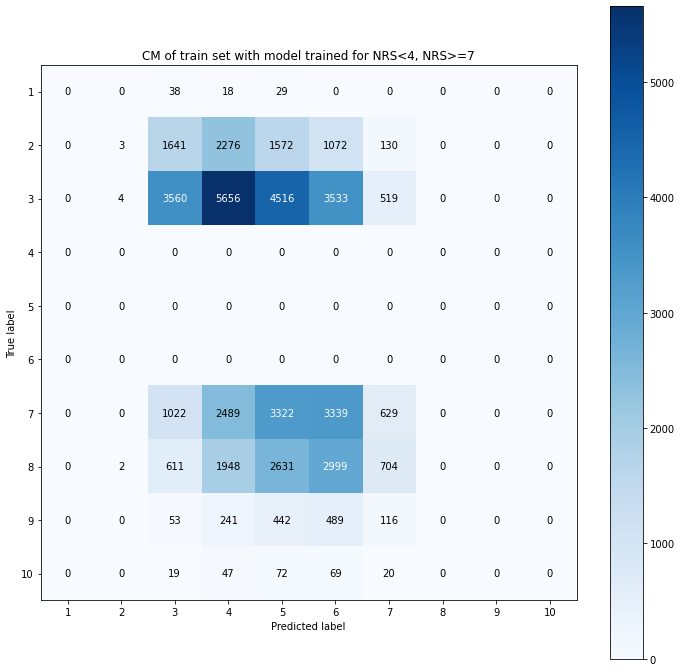

In [13]:
from scikitplot.metrics import plot_confusion_matrix
import tensorflow as tf


#x_trains = [x_train[:,:,1:2], agender_train[:]]


# 전체 test 샘플을 한번에 예측
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
with strategy.scope():
    y_pred3 = model1.predict(x_trains).flatten()

    
# labels for NRS 0 ~ 10
labels = []
for i in range(11):
    label = [0]*11
    label[i] = 1
    labels.append(label)

    
y_pred_label3 = np.array([int(round(y_pr/0.1)) for y_pr in y_pred3])
y_train_label3 = np.array(y_train1, int)

plot_confusion_matrix(
    y_train_label3, y_pred_label3, title='CM of train set with model trained for NRS<4, NRS>=7',
    figsize=(12,12))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


<AxesSubplot:title={'center':'CM of test set with model trained for NRS<4, NRS>=7'}, xlabel='Predicted label', ylabel='True label'>

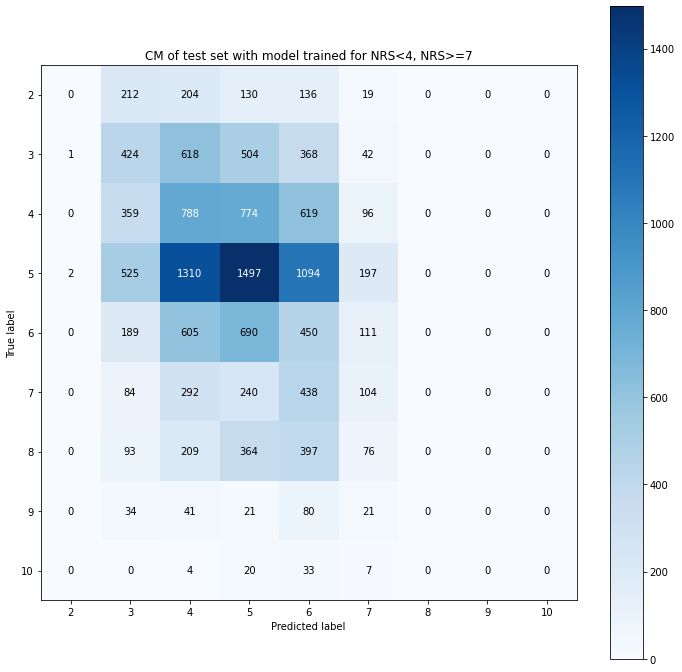

In [20]:
from scikitplot.metrics import plot_confusion_matrix


#x_trains0 = [signal.resample(x_train_pacu, 20*SRATE, axis=1), agender_train_pacu]
x_tests0 = [signal.resample(x_test_pacu[:,:,0:1], 20*SRATE, axis=1), agender_test_pacu]


strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
with strategy.scope():
    # 전체 test 샘플을 한번에 예측
    y_pred3 = model1.predict(x_tests0).flatten()

# labels for NRS 0 ~ 10
labels = []
for i in range(11):
    label = [0]*11
    label[i] = 1
    labels.append(label)

y_pred_label3 = np.array([int(round(y_pr/0.1)) for y_pr in y_pred3])
y_test_label3 = np.array(y_test_pacu, int)

plot_confusion_matrix(
    y_test_label3, y_pred_label3, title='CM of test set with model trained for NRS<4, NRS>=7',
    figsize=(12,12))